Соберите обучающую и проверочную выборку (просто запуская последовательно ячейки ноутбука).
Обучите полносвязную сеть.
Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.
Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.
Добавьте в сеть слои Dropout.
Добавьте в сеть слои BatchNormalization.
Поменяйте внутренние активационные функции, варианты: relu, elu, linear.
Поменяйте размер batch_size: маленький, средний и большой.
Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках.

### Классификация музыкальных жанров


In [ ]:
from google.colab import files
from tensorflow.keras.utils import to_categorical
import os # Работа с папками и файлами
import librosa # Параметризация аудио
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split # Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Базы/genres.zip' # распаковываем архив на google диске на локальный диск google colaboratory 

genres = os.listdir('genres') # получаем список папок в распакованной папке

# Проверяем выгруженные папки
!ls genres 
# И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Функция параметризации аудио
def get_features(y, sr):
  # Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # Мел кепстральные коэффициенты (по умолчанию 20)

  rmse = np.mean(librosa.feature.rms(y=y)) # Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) # Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Среднее частота пересечения нуля звукового временного ряда

  # Добавляем все параметры в один список
  out = []
  out.append(rmse) # добавляем среднеквадратичную амплитуду
  out.append(spec_cent) # добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля

  # Добавляем среднее всех Мел спектральных коэффициентов (20 коэффициентов)
  for e in mfcc:
    out.append(np.mean(e))
  
  # Добавляем среднее всех частот цветности (12 коэффициентов)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  # Возвращаем получившийся список размерностью (37,) 
  return out


In [ ]:
import time # Подключаем модуль time для подсчёта времени на обработку одного жанра

# Формируем обучающую выборку
# Создаём пустые листы
X_train = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] # Берём текущий жанр
  # Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    # Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    # Загружаем в y аудиосигнал
    # Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) # y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    # Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    # Добавляем строку в X_train
    X_train.append(out)
    # Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  # Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

# Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 47c
Жанр pop готов -> 46c
Жанр jazz готов -> 46c
Жанр disco готов -> 46c
Жанр metal готов -> 46c
Жанр rock готов -> 46c
Жанр hiphop готов -> 46c
Жанр country готов -> 46c
Жанр reggae готов -> 47c
Жанр classical готов -> 48c


In [ ]:
# Создаем backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов, для проверки правильности заполнения
# И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
# Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
# Нормируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[ 0.7836918  -0.35772027 -0.30473442 -0.25148146 -0.42644735  0.61386262
  0.23949    -0.75624323  1.2505172   0.10085314  1.69521952 -0.59500804
  0.99559827 -0.50934854  0.8953703  -0.61743767  1.20167325 -0.80499461
  0.15592333 -0.49888842  0.40394788 -1.04455432 -0.21563257 -0.17358027
  0.47123137  0.35747027 -0.41259566 -0.03411814  0.49638067  0.53024633
 -0.10954923  0.40591612 -0.78910405 -0.42989418 -0.04507599  0.57936577
  1.75613778]


In [ ]:
# Разделяем выборку на обучающую и проверочную
# Для проверочной используем 10 % примеров, так как база маленькая
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train_class, test_size = 0.1)

In [ ]:
# Выводим размеры обучающей и проверочной выборок для проверки
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


### Создаем нейронку

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128,activation='elu'))
model.add(Dense(64,activation='elu'))
model.add(Dense(32,activation='elu'))
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 150,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

Epoch 1/150
45/45 [==============================] - 1s 8ms/step - loss: 2.0418 - accuracy: 0.2956 - val_loss: 1.8582 - val_accuracy: 0.3400
Epoch 2/150
45/45 [==============================] - 0s 4ms/step - loss: 1.7471 - accuracy: 0.3956 - val_loss: 1.6850 - val_accuracy: 0.4000
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5922 - accuracy: 0.4400 - val_loss: 1.5926 - val_accuracy: 0.4300
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4850 - accuracy: 0.4956 - val_loss: 1.5316 - val_accuracy: 0.4800
Epoch 5/150
45/45 [==============================] - 0s 4ms/step - loss: 1.4031 - accuracy: 0.5378 - val_loss: 1.4757 - val_accuracy: 0.5000
Epoch 6/150
45/45 [==============================] - 0s 4ms/step - loss: 1.3336 - accuracy: 0.5656 - val_loss: 1.4403 - val_accuracy: 0.5000
Epoch 7/150
45/45 [==============================] - 0s 4ms/step - loss: 1.2754 - accuracy: 0.5833 - val_loss: 1.3989 - val_accuracy: 0.5200
Epoch 8/150
4

In [ ]:
model.save_weights('model.h5')
model.load_weights('model.h5')

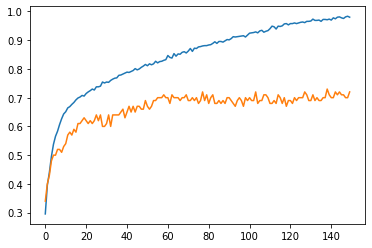

In [ ]:
# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Полносвязная сеть из 5 Dense слоев с функцией активации elu, показала точность 72 % при 150 эпохах обучения.

### Распознавание жанра песни

In [ ]:
# Выбираем песню для распознавания
songname = './genres/rock/rock.00000.au'
# Получаем аудиосигнал
y, sr = librosa.load(songname, mono=True, duration=30)
# Параметризуем сигнал
out = get_features(y, sr)

In [ ]:
# Добавляем ону размерность, этого требует model.predict
out = np.array(out).reshape(1,37) 

In [ ]:
out.shape

(1, 37)

In [ ]:
# Делаем преобразование с помощью scaler, обученного на обучающей выборке
out = scaler.transform(out)

In [ ]:
print(out)

[[-0.02690168 -0.28780161 -0.27660395 -0.21895271 -0.32147562  0.27819525
   0.31028501 -0.6560526   0.26401821 -0.87942109  0.71996312 -1.0330064
   0.47878835 -0.78838961  0.62573781 -0.71319524  0.60099553 -1.09968752
   0.08155268 -0.47732058  0.18880687 -0.87535322  0.40799885 -0.01668229
  -0.11444061 -0.07569836  1.12639651  0.89248672  0.40919869  0.74039901
  -0.40429014 -0.664512   -0.58669357  0.08835723  0.88386334 -0.76529218
  -0.85039482]]


In [ ]:
# Делаем preict
y = model.predict(out)

In [ ]:
# Выводим выход с softmax
print(y)
# и распознанный класс
print(np.argmax(y))
# Проверяем правильный индекс исходного жанра
print(genres.index("rock"))

[[2.8221977e-03 3.4136447e-05 6.0200509e-05 2.7682928e-02 2.0438805e-03
  8.3158511e-01 1.4057806e-02 3.0403247e-02 9.1286562e-02 2.3975539e-05]]
5
5


### Простая полносвязная сеть с одним скрытым слоем


In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(64,activation='elu'))
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

Epoch 1/250
45/45 [==============================] - 1s 6ms/step - loss: 2.0721 - accuracy: 0.2411 - val_loss: 1.8815 - val_accuracy: 0.3500
Epoch 2/250
45/45 [==============================] - 0s 4ms/step - loss: 1.7540 - accuracy: 0.3700 - val_loss: 1.7108 - val_accuracy: 0.4000
Epoch 3/250
45/45 [==============================] - 0s 3ms/step - loss: 1.5932 - accuracy: 0.4189 - val_loss: 1.6172 - val_accuracy: 0.3700
Epoch 4/250
45/45 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.4589 - val_loss: 1.5602 - val_accuracy: 0.4000
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 1.4178 - accuracy: 0.4911 - val_loss: 1.5237 - val_accuracy: 0.3900
Epoch 6/250
45/45 [==============================] - 0s 3ms/step - loss: 1.3600 - accuracy: 0.5300 - val_loss: 1.4956 - val_accuracy: 0.4200
Epoch 7/250
45/45 [==============================] - 0s 3ms/step - loss: 1.3109 - accuracy: 0.5433 - val_loss: 1.4741 - val_accuracy: 0.4400
Epoch 8/250
4

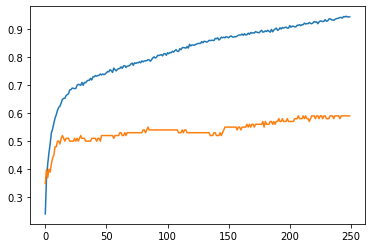

In [ ]:
# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# В полносвязной сети из трех Dense слоев снижение их количества привело к потере точности. Потенциал дообучения не представляется большим. Значение на обучающей выборке уже близко к 1.


### Сложная многослойная сеть

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(512,activation='elu'))
model.add(Dense(128,activation='elu'))
model.add(Dense(64,activation='elu'))
model.add(Dense(32,activation='elu'))
model.add(Dense(16,activation='elu'))
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
45/45 [==============================] - 2s 16ms/step - loss: 1.8498 - accuracy: 0.3889 - val_loss: 1.7348 - val_accuracy: 0.3900
Epoch 2/250
45/45 [==============================] - 1s 12ms/step - loss: 1.5505 - accuracy: 0.5156 - val_loss: 1.5969 - val_accuracy: 0.4800
Epoch 3/250
45/45 [==============================] - 1s 12ms/step - loss: 1.3985 - accuracy: 0.5711 - val_loss: 1.5548 - val_accuracy: 0.5300
Epoch 4/250
45/45 [==============================] - 0s 11ms/step - loss: 1.2916 - accuracy: 0.6033 - val_loss: 1.5062 - val_accuracy: 0.5500
Epoch 5/250
45/45 [==============================] - 1s 12ms/step - loss: 1.2036 - accuracy: 0.6556 - val_loss: 1.4595 - val_accuracy: 0.5500
Epoch 6/250
45/45 [==============================] - 0s 11ms/step - loss: 1.1330 - accuracy: 0.6711 - val_loss: 1.4161 - val_accuracy: 0.6100
Epoch 7/250
45/45 [==============================] - 1s 12ms/step - loss: 1.0680 - accuracy: 0.6911 - val_loss: 1.3891 - val_accuracy: 0.6100
Epoch 

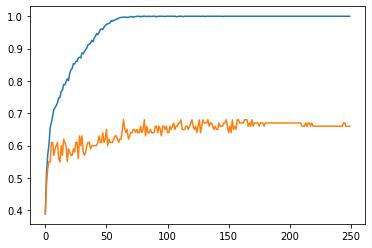

In [ ]:
# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть из 7 Dense слоев с функцией активации elu. Точность улучшилась по сравнению с трехслойной моделью. Потенциал для роста практически исчерпан на уровне 66 %. Точность на проверочном графике 1.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
45/45 [==============================] - 2s 18ms/step - loss: 1.9902 - accuracy: 0.2544 - val_loss: 1.7276 - val_accuracy: 0.3900
Epoch 2/250
45/45 [==============================] - 1s 13ms/step - loss: 1.7358 - accuracy: 0.3900 - val_loss: 1.6133 - val_accuracy: 0.3800
Epoch 3/250
45/45 [==============================] - 1s 12ms/step - loss: 1.6939 - accuracy: 0.4111 - val_loss: 1.5744 - val_accuracy: 0.4000
Epoch 4/250
45/45 [==============================] - 1s 12ms/step - loss: 1.5891 - accuracy: 0.4467 - val_loss: 1.5574 - val_accuracy: 0.4200
Epoch 5/250
45/45 [==============================] - 1s 12ms/step - loss: 1.5538 - accuracy: 0.4811 - val_loss: 1.5382 - val_accuracy: 0.4600
Epoch 6/250
45/45 [==============================] - 1s 13ms/step - loss: 1.5173 - accuracy: 0.4689 - val_loss: 1.5285 - val_accuracy: 0.4700
Epoch 7/250
45/45 [==============================] - 1s 12ms/step - loss: 1.4189 - accuracy: 0.5178 - val_loss: 1.4790 - val_accuracy: 0.5400
Epoch 

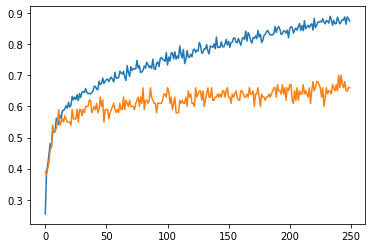

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='elu'))
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть из 7 Dense слоев с функцией активации elu. Дополнена 4 слоями Dropout(0.25) не поменяло точность сети - 66 %. Однако оставило небольшой запас для дообучения, т.к. точность на проверочной выборке 0.8744, а тренд на проверочной выборке имеет тенденцию к росту. Признаков переообучения нет. Однако не меняем количество эпох для чистоты эксперимента.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
45/45 [==============================] - 3s 19ms/step - loss: 2.2275 - accuracy: 0.2089 - val_loss: 1.9108 - val_accuracy: 0.4000
Epoch 2/250
45/45 [==============================] - 1s 13ms/step - loss: 1.9422 - accuracy: 0.2978 - val_loss: 1.8179 - val_accuracy: 0.4300
Epoch 3/250
45/45 [==============================] - 1s 14ms/step - loss: 1.8679 - accuracy: 0.3400 - val_loss: 1.7680 - val_accuracy: 0.4400
Epoch 4/250
45/45 [==============================] - 1s 13ms/step - loss: 1.7879 - accuracy: 0.3567 - val_loss: 1.6976 - val_accuracy: 0.4200
Epoch 5/250
45/45 [==============================] - 1s 13ms/step - loss: 1.7233 - accuracy: 0.3889 - val_loss: 1.6540 - val_accuracy: 0.4900
Epoch 6/250
45/45 [==============================] - 1s 14ms/step - loss: 1.6458 - accuracy: 0.4578 - val_loss: 1.6160 - val_accuracy: 0.4600
Epoch 7/250
45/45 [==============================] - 1s 13ms/step - loss: 1.6465 - accuracy: 0.4400 - val_loss: 1.5924 - val_accuracy: 0.4400
Epoch 

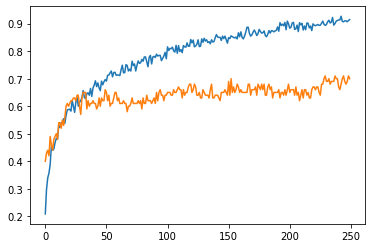

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='elu'))
model.add(BatchNormalization())
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть из 7 Dense слоев с функцией активации elu, 4 слоев Dropout и 3 слоев BatchNormalization .Добавление двух слоев нормализации между слоями и одного перед выходным слоем революции не сделало, но позволило увидеть более высокие показатели точности - порядка 70-71 %. Потенциал дообучения также не исчерпан - точность на тестовой выборке 0.9144. На графике точности на проверочной выборке прослеживается растущий тренд.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
9/9 [==============================] - 2s 59ms/step - loss: 2.3933 - accuracy: 0.1733 - val_loss: 2.0049 - val_accuracy: 0.3100
Epoch 2/250
9/9 [==============================] - 0s 28ms/step - loss: 2.1103 - accuracy: 0.2522 - val_loss: 1.9175 - val_accuracy: 0.3700
Epoch 3/250
9/9 [==============================] - 0s 29ms/step - loss: 1.9481 - accuracy: 0.3056 - val_loss: 1.8697 - val_accuracy: 0.3900
Epoch 4/250
9/9 [==============================] - 0s 27ms/step - loss: 1.8972 - accuracy: 0.3211 - val_loss: 1.8272 - val_accuracy: 0.4400
Epoch 5/250
9/9 [==============================] - 0s 28ms/step - loss: 1.8475 - accuracy: 0.3411 - val_loss: 1.8041 - val_accuracy: 0.4400
Epoch 6/250
9/9 [==============================] - 0s 29ms/step - loss: 1.7914 - accuracy: 0.3800 - val_loss: 1.7828 - val_accuracy: 0.4300
Epoch 7/250
9/9 [==============================] - 0s 26ms/step - loss: 1.7518 - accuracy: 0.4067 - val_loss: 1.7552 - val_accuracy: 0.4300
Epoch 8/250
9/9 [===

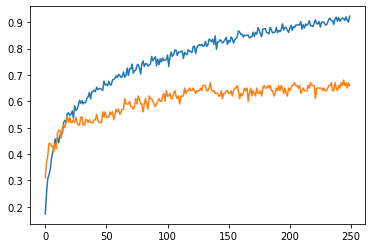

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='elu'))
model.add(BatchNormalization())
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 100,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Увеличение размера batch_size  до значения равного 100 понизило показатели точности до  66-67 %. Не забываем про стартовые весы, которые могли также повлиять. Поскольку архитектура полносвязной 7 слойной сети из Dense слоев сохранена.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
900/900 [==============================] - 11s 10ms/step - loss: 2.3029 - accuracy: 0.0944 - val_loss: 4755.2852 - val_accuracy: 0.0700
Epoch 2/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3029 - accuracy: 0.1022 - val_loss: 5820.6455 - val_accuracy: 0.0500
Epoch 3/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3028 - accuracy: 0.1056 - val_loss: 5587.9683 - val_accuracy: 0.0500
Epoch 4/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3027 - accuracy: 0.1056 - val_loss: 5305.7256 - val_accuracy: 0.0600
Epoch 5/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3027 - accuracy: 0.1056 - val_loss: 5451.8306 - val_accuracy: 0.0600
Epoch 6/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 5433.4238 - val_accuracy: 0.0800
Epoch 7/250
900/900 [==============================] - 8s 9ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 5259.5439

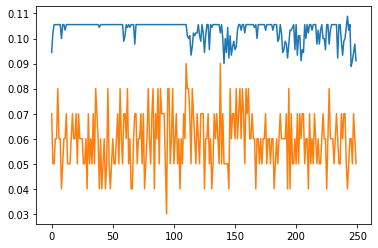

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(512,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='elu'))
model.add(BatchNormalization())
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 1,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## Полносвязная сеть из 7 Dense слоев с функцией активации elu, 4 слоев Dropout и 3 слоев BatchNormalization.Снижение размера batch_size до 1 привело к обрушению точности до уровня 5-7 %, по видимому связанному с динамической дестабилизацией весов, когда сеть пытается подстроиться под каждый батч и в результате не получает приемлемых значений адаптированных ко всей модели.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
45/45 [==============================] - 3s 18ms/step - loss: 2.6472 - accuracy: 0.1289 - val_loss: 2.2702 - val_accuracy: 0.1900
Epoch 2/250
45/45 [==============================] - 1s 13ms/step - loss: 2.5296 - accuracy: 0.1567 - val_loss: 2.2547 - val_accuracy: 0.2000
Epoch 3/250
45/45 [==============================] - 1s 13ms/step - loss: 2.4224 - accuracy: 0.1678 - val_loss: 2.2364 - val_accuracy: 0.2000
Epoch 4/250
45/45 [==============================] - 1s 13ms/step - loss: 2.3710 - accuracy: 0.1867 - val_loss: 2.1922 - val_accuracy: 0.2500
Epoch 5/250
45/45 [==============================] - 1s 13ms/step - loss: 2.2524 - accuracy: 0.2389 - val_loss: 2.1485 - val_accuracy: 0.3000
Epoch 6/250
45/45 [==============================] - 1s 13ms/step - loss: 2.1929 - accuracy: 0.2456 - val_loss: 2.0752 - val_accuracy: 0.3000
Epoch 7/250
45/45 [==============================] - 1s 13ms/step - loss: 2.1196 - accuracy: 0.2678 - val_loss: 1.9984 - val_accuracy: 0.2800
Epoch 

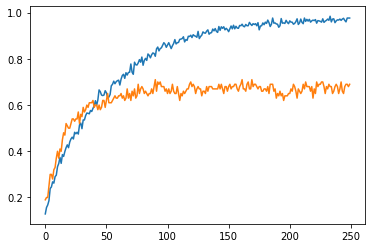

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть из 7 Dense слоев с функцией активации elu, 4 слоев Dropout и 3 слоев BatchNormalization. Замена в слоях функции активации на relu показала на выходе точность 69-70 % - сопоставимую с функцией elu.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/250
45/45 [==============================] - 3s 19ms/step - loss: 2.1475 - accuracy: 0.2400 - val_loss: 1.8795 - val_accuracy: 0.3600
Epoch 2/250
45/45 [==============================] - 1s 13ms/step - loss: 1.8720 - accuracy: 0.3444 - val_loss: 1.8321 - val_accuracy: 0.4100
Epoch 3/250
45/45 [==============================] - 1s 13ms/step - loss: 1.7437 - accuracy: 0.3944 - val_loss: 1.7887 - val_accuracy: 0.4100
Epoch 4/250
45/45 [==============================] - 1s 13ms/step - loss: 1.6982 - accuracy: 0.4189 - val_loss: 1.7603 - val_accuracy: 0.4000
Epoch 5/250
45/45 [==============================] - 1s 14ms/step - loss: 1.6900 - accuracy: 0.4189 - val_loss: 1.7077 - val_accuracy: 0.4200
Epoch 6/250
45/45 [==============================] - 1s 13ms/step - loss: 1.6460 - accuracy: 0.4411 - val_loss: 1.6647 - val_accuracy: 0.4300
Epoch 7/250
45/45 [==============================] - 1s 13ms/step - loss: 1.6234 - accuracy: 0.4433 - val_loss: 1.6320 - val_accuracy: 0.4400
Epoch 

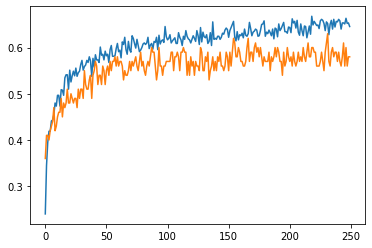

In [ ]:
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,37)

# Создаем полносвязную сеть
model = Sequential()
model.add(Dense(1024, activation='linear', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(512,activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='linear'))
model.add(BatchNormalization())
# В выходном слое количество нейронов равно количеству классов(жанров) и активация softmax
model.add(Dense(len(genres), activation = 'softmax'))

# Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    Y_train,
                    epochs = 250,
                    batch_size = 20,
                    validation_data = (X_test[:, indexes], Y_test))

# Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Полносвязная сеть из 7 Dense слоев с функцией активации elu, 4 слоев Dropout и 3 слоев BatchNormalization. Замена в слоях функции активации на linear привело к снижению точности до 58 %.

Общий вывод: 5-7 слоев при полносвязной архитектуре достаточное количество для обеспечения точности. Увеличение их количества может привести к снижению градиента, а сокращение количества слоев ограничило матричный потенциал модели для оценки. 
Слои Dropout не оказали влияния на точность модели, но позволили уменьшит риск переобучения придав графику более четкий растущий тренд. При увеличении количеств эпох, это может спасти от переобучения. 
Добавление слоев нормализации позволило повысить точность.
Функции elu и relu показали сопоставимые по точности результаты и свою эффективность для достижения цели. Применение функции linear уменьшило точность модели.